<p style="font-size:14pt;text-align:center;">
Training Fast R-CNN network on PascalVOC 2005.
</p>

In [62]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import theano
from theano import tensor as T
import pickle as pk
import re
from copy import deepcopy
import sys

# image processing
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2hsv, hsv2rgb

import lasagne
from lasagne.layers import Pool2DLayer, Conv2DLayer, dropout, \
    DenseLayer, InputLayer, get_output, get_all_params
    
import bnr_ml.objectdetect.fastrcnn as fastrcnn
import bnr_ml.utils.helpers as helpers

import pdb

In [31]:
with open('/usr/local/python/bnr_ml/data/PascalVOC/annotations.txt', 'rb') as f:
    annotations = pk.load(f)['annotations']

In [32]:
def add_proper_labels(annotations):
    for im in annotations:
        for obj in im:
            if 'car' in obj['label'].lower():
                obj['label'] = 'car'
            elif 'bicycle' in obj['label'].lower():
                obj['label'] = 'bicycle'
            elif 'person' in obj['label'].lower():
                obj['label'] = 'person'
            elif 'motorbike' in obj['label'].lower():
                obj['label'] = 'bike'
            elif 'bike' in obj['label'].lower():
                obj['label'] = 'bicycle'
            else:
                print obj

In [41]:
def get_label_counts(annotations):
    counts = np.zeros((4,))
    for im in annotations:
        for obj in im:
            if obj['label'] == 0:
                counts[0] += 1
            elif obj['label'] == 1:
                counts[1] += 1
            elif obj['label'] == 2:
                counts[2] += 1
            else:
                counts[3] += 1
    return counts

In [34]:
def get_num_from_label(obj):
    lab = obj['label'].lower()
    if 'car' == lab:
        obj['label'] = 0
    elif 'bicycle' == lab:
        obj['label'] = 1
    elif 'bike' == lab:
        obj['label'] = 2
    elif 'person' == lab:
        obj['label'] = 3
    else:
        obj['label'] = 4
    return obj

In [35]:
def fix_obj(obj):
    x, y = obj['p1'][0], obj['p1'][1]
    w, h = obj['p2'][0] - x, obj['p2'][1] - y
    obj['x'], obj['y'], obj['w'], obj['h'] = x, y, w, h
    del obj['p1'], obj['p2']
    return get_num_from_label(obj)

In [36]:
add_proper_labels(annotations)

In [37]:
annotations = [[fix_obj(obj) for obj in objs] for objs in annotations]

In [38]:
annotations = np.asarray(annotations)

In [42]:
counts = get_label_counts(annotations)

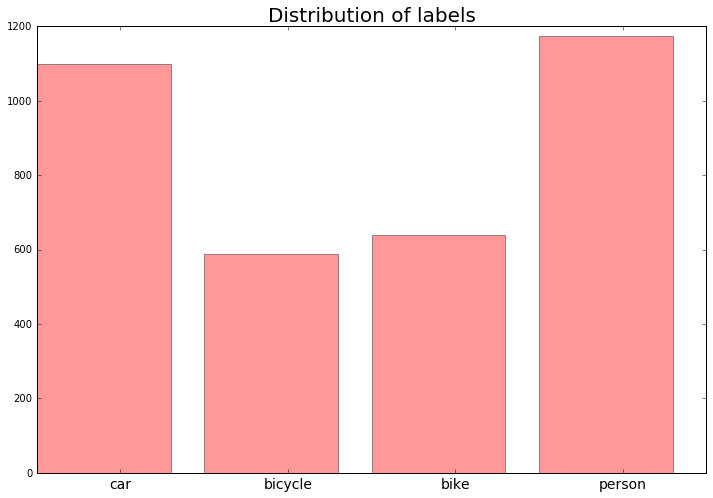

In [43]:
plt.figure(figsize=(12,8))
plt.title('Distribution of labels', fontsize=20)
plt.bar(np.arange(counts.size), counts, color='red', alpha=.4)
plt.xticks(np.arange(counts.size) + .5, ['car', 'bicycle', 'bike', 'person'], fontsize=14)
plt.show()

In [44]:
np.random.seed(1991)

<b>Split the annotations for training and testing, the reason I split by image and not individual object is so that when testing the performance, the network will never have seen any part of the test image.

In [13]:
with open('indices.pkl', 'rb') as f:
    indices = pk.load(f)
    train_idx = indices['train_index']
    test_idx = indices['test_index']

In [47]:
train_annotations = annotations[train_idx]
test_annotations = annotations[test_idx]

<b>Fix annotations so that you can use the static method for generating data for fast r-cnn.</b>

<b>Now we define the net for recognition.</b>

In [49]:
num_epochs = 1000
batch_size = 50

In [50]:
num_classes = 4

In [66]:
input_shape = (224,224)
net = {}
net['input'] = InputLayer((None,3) + input_shape)
net['conv1'] = Conv2DLayer(net['input'], 16, (3,3))
net['conv2'] = Conv2DLayer(net['conv1'], 16, (3,3))
net['pool1'] = Pool2DLayer(net['conv2'], (2,2))
net['conv3'] = Conv2DLayer(net['pool1'], 32, (3,3))
net['conv4'] = Conv2DLayer(net['conv3'], 32, (3,3))
net['pool2'] = Pool2DLayer(net['conv4'], (2,2))
net['conv5'] = Conv2DLayer(net['pool2'], 64, (3,3))
net['conv6'] = Conv2DLayer(net['conv5'], 64, (3,3))
net['conv7'] = Conv2DLayer(net['conv6'], 64, (1,1))
net['pool3'] = Pool2DLayer(net['conv7'], (2,2))
net['conv8'] = Conv2DLayer(net['pool3'], 128, (3,3))
net['conv9'] = Conv2DLayer(net['conv8'], 128, (3,3))
net['conv10'] = Conv2DLayer(net['conv9'], 128, (1,1))
net['pool4'] = Pool2DLayer(net['conv10'], (2,2))
net['conv11'] = Conv2DLayer(net['pool4'], 128, (3,3))
net['conv12'] = Conv2DLayer(net['conv11'], 128, (3,3))
net['conv13'] = Conv2DLayer(net['conv12'], 128, (1,1))


net['dense1'] = DenseLayer(dropout(net['conv13'], p=.5), 2048)
# net['dense2'] = DenseLayer(dropout(net['dense1'], p=.5), 2048)
net['dense2'] = DenseLayer(dropout(net['dense1'], p=.5), (2 * 5 + 4) * (6*6))
net['output'] = DenseLayer(dropout(net['dense2'], p=.5), 5, nonlinearity=lasagne.nonlinearities.softmax)

<b>Load pre-trained weights</b>

In [67]:
load_pretrained = True
if load_pretrained:
    with open('pretrained_weights_2.pkl', 'rb') as f:
        weights = pk.load(f)
        lasagne.layers.set_all_param_values(net['output'], weights)

<b>Add extra layers to network for detection</b>

In [68]:
net['detect'] = net['output']
net['localize'] = DenseLayer(dropout(net['dense2'], p=.5), (num_classes + 1) * 4)

In [69]:
load_weights = False
if load_weights:
    with open('yolo_weights.pkl', 'rb') as f:
        weights = pk.load(f)
        lasagne.layers.set_all_param_values(net['output'], weights)

<b>Train the network

In [92]:
reload(fastrcnn)

<module 'bnr_ml.objectdetect.fastrcnn' from '/usr/local/python/bnr_ml/objectdetect/fastrcnn.py'>

In [93]:
detector = fastrcnn.FastRCNNDetector(net, num_classes)

In [88]:
train_gen = fastrcnn.FastRCNNDetector.generate_data(train_annotations, input_shape, num_classes, num_rios=25)
test_gen = fastrcnn.FastRCNNDetector.generate_data(test_annotations, input_shape, num_classes, num_rios=25)

In [89]:
print_obj = helpers.NotebookPrinter(open('/dev/stdout', 'w'), sys.stdout)

In [90]:
train_loss, test_loss = detector.train(
    train_gen,
    test_gen,
    print_obj,
    lr=1e-5,
    lmbda=0.
)

Getting cost...
Compiling...
Compiling took 20.282 seconds
Beginning training
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(109)train()
-> err = train_fn(Xbatch, ybatch)
(Pdb) n
ValueError: ValueErr... node.",)
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(109)train()
-> err = train_fn(Xbatch, ybatch)
(Pdb) c


ValueError: Input dimension mis-match. (input[0].shape[0] = 4, input[1].shape[0] = 50)
Apply node that caused the error: Elemwise{mul,no_inplace}(InplaceDimShuffle{0,x}.0, Subtensor{::, int64::}.0)
Toposort index: 115
Inputs types: [TensorType(float64, col), TensorType(float64, matrix)]
Inputs shapes: [(4, 1), (50, 5)]
Inputs strides: [(8, 8), (72, 8)]
Inputs values: [array([[ 0.02],
       [ 0.02],
       [ 0.02],
       [ 0.02]]), 'not shown']
Outputs clients: [[Sum{axis=[1], acc_dtype=float64}(Elemwise{mul,no_inplace}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [91]:
N = 10
detect = theano.shared(np.random.rand(N, 5))
localize = theano.shared(np.random.rand(N, 5, 4))
target = theano.shared(np.random.rand(N, 9))

In [94]:
detector._get_cost(detect, localize, target)

> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(62)_get_cost()
-> cost = categorical_crossentropy(detection_output, target[:,-(self.num_classes + 1):])
(Pdb) mask.shape.eval()
array([10])
(Pdb) n
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(63)_get_cost()
-> cost += lmbda * mask * T.sum(smooth_l1(localization_output[:,class_idx] - target[:,:4]), axis=1)
(Pdb) cost.shape.eval()
array([10])
(Pdb) class_idx.eval()
array([3, 1, 3, 1, 2, 3, 3, 2, 0, 0])
(Pdb) n
> /usr/local/python/bnr_ml/objectdetect/fastrcnn.py(65)_get_cost()
-> return T.mean(cost)
(Pdb) cost.eval()
*** ValueError: Input dimension mis-match. (input[0].shape[1] = 10, input[3].shape[1] = 4)
Apply node that caused the error: Elemwise{Composite{(i0 + Switch(i1, i2, i3))}}[(0, 3)](Elemwise{Neg}[(0, 0)].0, Elemwise{eq,no_inplace}.0, TensorConstant{(1, 1) of 0}, Sum{axis=[1], acc_dtype=float64}.0)
Toposort index: 15
Inputs types: [TensorType(float64, row), TensorType(int8, row), TensorType(int8, (True, True)), TensorTy

BdbQuit: 